In [49]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC 
from selenium.webdriver.common.by import By
from selenium.webdriver import Chrome
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import json
from os.path import isfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer


WebScrapper

In [50]:
def startDriver(url:str) -> webdriver.Chrome:
	service = Service(ChromeDriverManager().install())
	options = Options()
	options.add_argument("--disable-extensions")
	options.add_argument("--headless")
	driver = Chrome(service=service, options=options)

	driver.get(f"{url}")
	
	WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button.align-right.secondary.slidedown-button"))).click()
	WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button.banner__close.privacy__banner"))).click()
	WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button.spirit-family-select__button.js-select-spirit-family.all.selected"))).click()
	WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'button[data-value="agave"]'))).click()
	return driver

In [51]:
def extractLinks(url:str) -> list: 
    
    driver = startDriver(url)

    hrefs = []

    for x in range(1, 51):
        driver.get(f"{url}{x}")
        elements = driver.find_elements(By.CSS_SELECTOR, "li.spirit.agave-content")
        for element in elements:
            hrefs.append(element.find_element(By.TAG_NAME, "a").get_attribute("href"))
   
    driver.quit()

    return hrefs

In [52]:
def extractProductDetails(hrefs:list, url:str) -> pd.DataFrame:
    
    df = pd.DataFrame(columns=['name', 'type', 'cask', 'location', 'age', 'abv %', 'cost', 
    'badge', '# ratings', "community rating", 'flavor summary', 'expert', 
    'expert score', 'smoky', 'earthy', 'spicy', 'herbal', 'oily', 'bitter', 
    'rich', 'sweet', 'mineral', 'salty', 'umami', 'tart', 'fruity', 
    'floral'])

    driver = startDriver(url)

    for href in hrefs:
        driver.get(href)
        
        #Nombre
        try:
            name = driver.find_element(By.XPATH, "/html/body/div[7]/div/div/main/div/div[1]/div[1]/div[3]/h1").text
            if name == "":
                name = "unknown"
        except:
            name = "unknown"
        #Tipo

        try:   
            types = driver.find_element(By.XPATH,"/html/body/div[7]/div/div/main/div/div[1]/div[1]/div[3]/div/p[1]").text
            if types == "":
                types = pd.NA
        except:
            types = pd.NA
        #Cask
        try:
            cask = driver.find_element(By.XPATH,"/html/body/div[7]/div/div/main/div/div[1]/div[2]/div[1]/div/div/div[2]/div[3]/ul/li[3]/div[2]").text
            if cask == "":
                cask = "unknown"    
        except:
            cask = "unknown"
        #Location y badge

        try:
            temp = driver.find_element(By.XPATH,"/html/body/div[7]/div/div/main/div/div[1]/div[1]/div[3]/div/p[2]").text.split("// ")

            location = temp[1]
            badge = temp[0]

            if location == "":
                location = "unknown"
            if badge == "":
                badge = "unknown"
        except:
            location = "unknown"
            badge = "unknown"

        #age

        try:
            age = driver.find_element(By.XPATH,"/html/body/div[7]/div/div/main/div/div[1]/div[2]/div[1]/div/div/div[2]/div[3]/ul/li[1]/ul/li[1]/div[2]").text
            if age == "":
                age = "unknown"
        except:
            age = "unknown"

        #ABV
        try:
            abv = driver.find_element(By.XPATH,"/html/body/div[7]/div/div/main/div/div[1]/div[2]/div[1]/div/div/div[2]/div[3]/ul/li[1]/ul/li[3]/div[2]").text
            if abv == "":
                abv = pd.NA 
        except:
            abv = pd.NA

        #Cost
        try:
            cost = driver.find_element(By.XPATH, "/html/body/div[7]/div/div/main/div/div[1]/div[2]/div[1]/div/div/div[2]/div[3]/ul/li[1]/ul/li[2]/div[2]/div").get_attribute("class")[-1]
            if cost == "":  
                cost = pd.NA
        except:
            cost = pd.NA

        #Ratings
        try:
            ratings = driver.find_element(By.XPATH,"/html/body/div[7]/div/div/main/div/div[1]/div[2]/div[1]/div/div/div[1]/div/div/div/div/div[3]/a/span[2]").text
            if ratings == "":
                ratings = "unknown"
        except:
            ratings = "unknown"

        #Community Rating
        try:
            community_rating = driver.find_element(By.XPATH,"/html/body/div[7]/div/div/main/div/div[1]/div[2]/div[1]/div/div/div[1]/div/div/div/div/div[1]/span").text
            if community_rating == "" or community_rating == "No one has reviewed this yet. Be the first":
                community_rating = "unknown"
        except:
            community_rating = "unknown"

        #Flavor Summary
        try:
            flavor_summary = driver.find_element(By.XPATH,"/html/body/div[7]/div/div/main/div/div[1]/div[2]/div[1]/div/div/div[5]/h3").text
            if flavor_summary == "":
                flavor_summary = "unknown"
        except:
            flavor_summary = "unknown"  

        #Expert
        try:
            expert = driver.find_element(By.XPATH,"/html/body/div[7]/div/div/main/div/div[1]/div[2]/div[1]/div/div/div[3]/div[2]/div[1]/a").text
            if expert == "":
                expert = "unknown"
        except:
            expert = "unknown"

        #Expert Score
        try:
            expert_score = driver.find_element(By.XPATH,"/html/body/div[7]/div/div/main/div/div[1]/div[2]/div[1]/div/div/div[3]/div[2]/div[2]/span").text
            if expert_score == "":
                expert_score = "unknown"
        except:
            expert_score = "unknown"
        

        #Flavor Profile
        try:
            canvas_element = driver.find_element(By.XPATH, "/html/body/div[7]/div/div/main/div/div[1]/div[2]/div[1]/div/div/div[5]/canvas")
            data_flavors = canvas_element.get_attribute("data-flavors")
            df_2 = pd.DataFrame([json.loads(data_flavors)])
        except:
            df_2 = pd.DataFrame([{
                'smoky': pd.NA,
                'earthy': pd.NA,
                'spicy': pd.NA,
                'herbal': pd.NA,
                'oily': pd.NA,
                'bitter': pd.NA,
                'rich': pd.NA,
                'sweet': pd.NA,
                'mineral': pd.NA,
                'salty': pd.NA,
                'umami': pd.NA,
                'tart': pd.NA,
                'fruity': pd.NA,
                'floral': pd.NA
            }])

        #Create df_1
        df_1 = {
            'name': name,
            'type': types,
            'cask': cask,
            'location': location,
            'age': age,
            'abv %': abv,
            'cost': cost,
            'badge': badge,
            '# ratings': ratings,
            'community rating': community_rating,
            'flavor summary': flavor_summary,
            'expert': expert,
            'expert score': expert_score
        }

        df_1 = pd.DataFrame([df_1])
        

        #Concatenate df_1 and df_2
        df_1 = pd.concat([df_1, df_2], axis=1)

        #Append to df
        df = pd.concat([df, df_1], ignore_index=True)

    return df

In [53]:
def get_df() -> pd.DataFrame:
    url = "https://distiller.com/search?page="
    hrefs = extractLinks(url)
    df = extractProductDetails(hrefs, url)

    df = df.dropna()
    df.to_csv("distiler.csv", index=False)
    return df


In [54]:
if not isfile("distiler.csv"):
    get_df().to_csv("distiler.csv", index=False)

In [55]:
data = pd.read_csv("distiler.csv")

In [56]:
data["cask"].fillna("Unknown", inplace=True)
data["abv %"].fillna(data["abv %"].median(), inplace=True)

print("\nValores faltantes después de limpieza:")
print(data.isnull().sum())


Valores faltantes después de limpieza:
name                0
type                0
cask                0
location            0
age                 0
abv %               0
cost                0
badge               0
# ratings           0
community rating    0
flavor summary      0
expert              0
expert score        0
smoky               0
earthy              0
spicy               0
herbal              0
oily                0
bitter              0
rich                0
sweet               0
mineral             0
salty               0
umami               0
tart                0
fruity              0
floral              0
dtype: int64


In [57]:
# Trasformacion de flavor summary a lista
data[['flavor summary 1', 'flavor summary 2']] = data['flavor summary'].str.split('&', expand=True)
data['flavor summary 1'] = data['flavor summary 1'].str.strip()  
data['flavor summary 2'] = data['flavor summary 2'].str.strip()
data['flavor summary 2'].fillna(data['flavor summary 1'], inplace=True)
data['flavor summary'] = data[['flavor summary 1','flavor summary 2']].values.tolist()
data.drop(columns=['flavor summary 1', 'flavor summary 2'], inplace=True)

In [58]:
# Seleccion de datos para el modelo

# Los posibles predictores son: 'type', 'abv %', 'cost', '# ratings', 'community rating', 'expert score', 'flavor summary', 'smoky', 'earthy', 'spicy', 'herbal', 
# 'oily', 'bitter', 'rich', 'sweet', 'mineral', 'salty', 'umami', 'tart', 'fruity', 'floral', 'Expert'
# Descardado los demas predictores por no ser relevantes o tener demaciados valores faltantes

# Variable cualitativa diponible: 'type', 'flavor summary', 'Expert'

def get_df_predictors(predictors: list) -> pd.DataFrame:

    data_cleaned = data[predictors]

    try:
        mlb = MultiLabelBinarizer()
        one_hot_encoded = pd.DataFrame(mlb.fit_transform(data_cleaned['flavor summary']), columns=mlb.classes_)
        data_cleaned = pd.concat([data_cleaned, one_hot_encoded], axis=1)
        data_cleaned.drop(columns=['flavor summary'], inplace=True)
    except:
        pass

    try:
        one_hot = pd.get_dummies(data_cleaned['type'], prefix='type')
        data_cleaned.drop('type', axis=1, inplace=True)
        data_cleaned = data_cleaned.join(one_hot)
    except:
        pass

    try:
        one_hot = pd.get_dummies(data_cleaned['Expert'], prefix='Expert')
        data_cleaned.drop('Expert', axis=1, inplace=True)
        data_cleaned = data_cleaned.join(one_hot)
    except:
        pass
        
    data_cleaned = data_cleaned.replace('unknown', pd.NA)
    data_cleaned.dropna(inplace=True)

    

    
    return data_cleaned

In [59]:
predictors = ['type', 'abv %', 'cost', '# ratings', 'community rating', 'expert score', 'smoky', 'earthy', 'spicy', 'herbal', 
 'oily', 'bitter', 'rich', 'sweet', 'mineral', 'salty', 'umami', 'tart', 'fruity', 'floral']
data_cleaned = get_df_predictors(predictors)
data_cleaned.to_csv("data.csv", index=False)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_26756\1504148870.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned.drop('type', axis=1, inplace=True)


Importacion de datos

In [60]:
data = pd.read_csv("data.csv")

### Reducción de Dimensionalidad 

Aplicar PCA y t-SNE para reducir la dimensionalidad de los datos. Visualizar los datos en 2D y 3D 
usando los componentes obtenidos. [15 puntos] 

PCA

In [65]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

In [67]:
# Aplicar PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data)
pca

PCA(n_components=3)

Visualización 2D usando PCA

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_26756\862042004.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[0].scatter(pca_result[:, 0], pca_result[:, 1], c='blue', cmap='viridis')
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_26756\862042004.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[1].scatter(pca_result[:, 1], pca_result[:, 2], c='blue', cmap='viridis')
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_26756\862042004.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[2].scatter(pca_result[:, 2], pca_result[:, 0], c='blue', cmap='viridis')


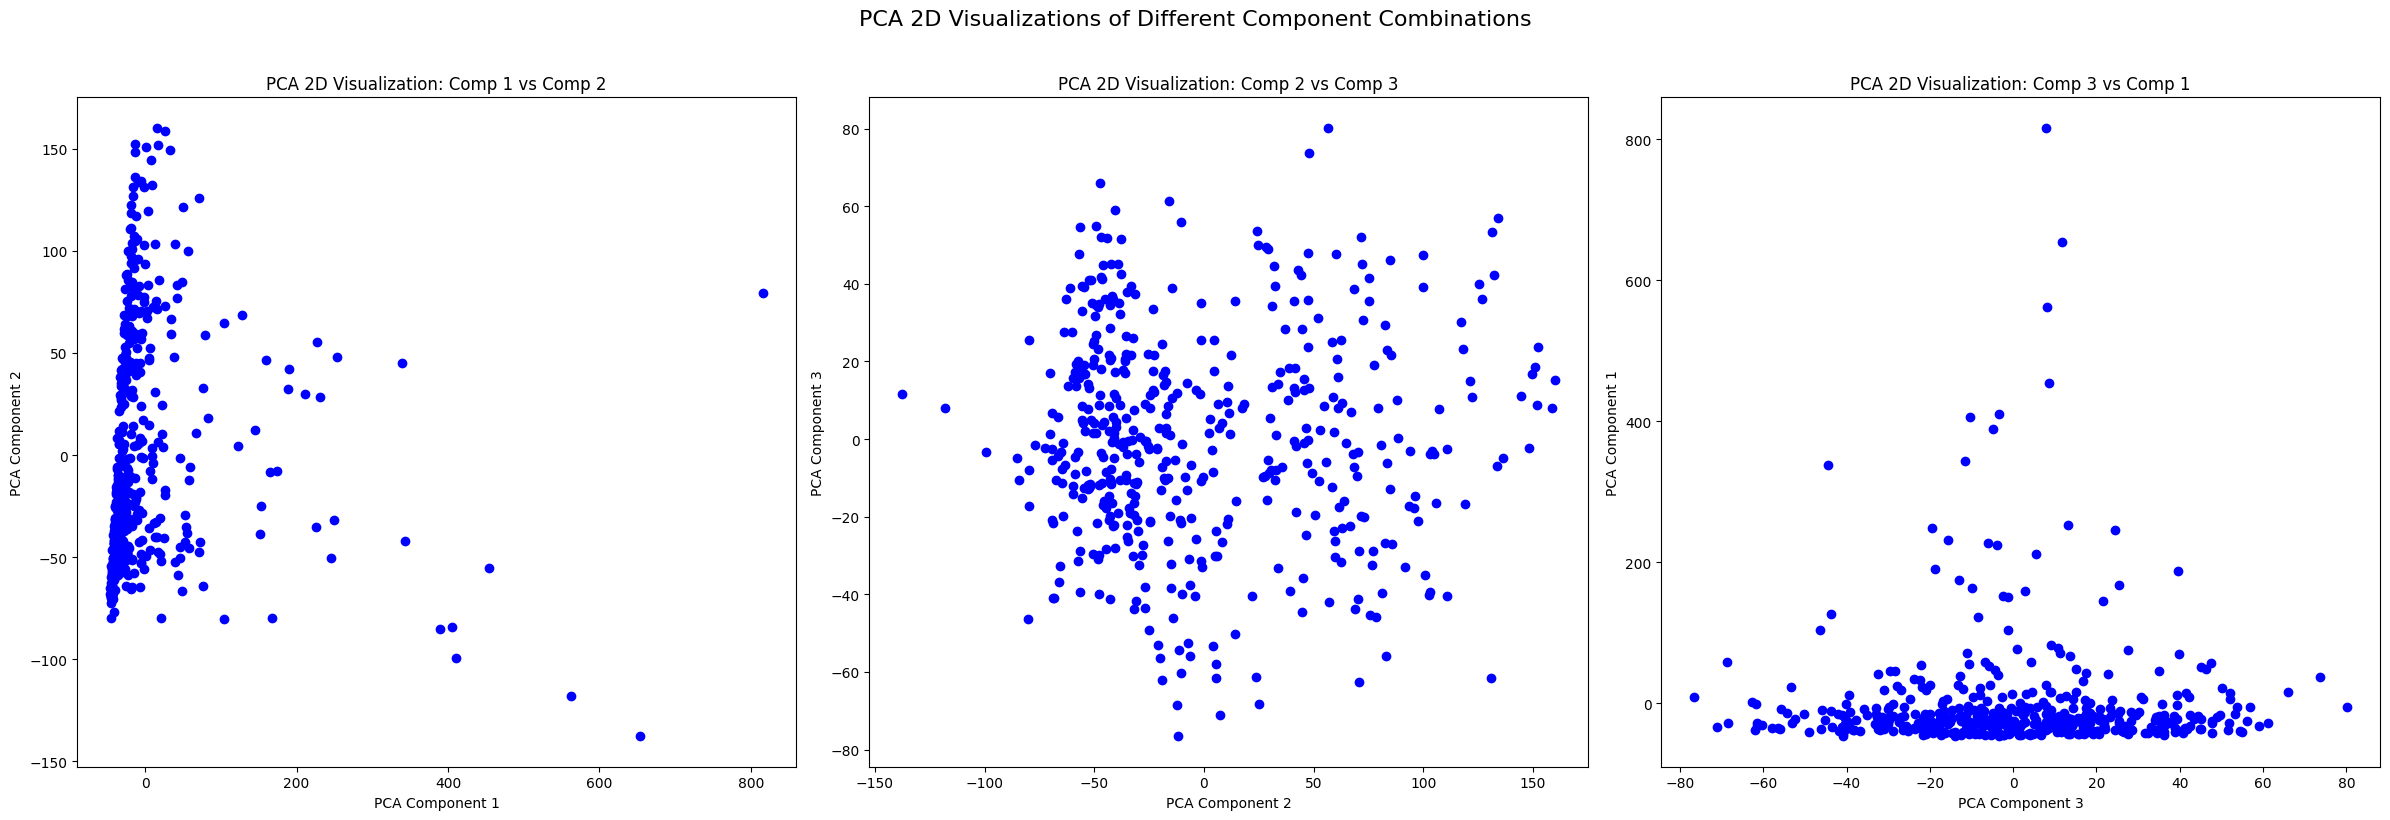

In [68]:
# Visualización 2D de los pca components
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('PCA 2D Visualizations of Different Component Combinations', fontsize=16, y=1.02)

# Primer subplot
axes[0].scatter(pca_result[:, 0], pca_result[:, 1], c='blue', cmap='viridis')
axes[0].set_xlabel('PCA Component 1')
axes[0].set_ylabel('PCA Component 2')
axes[0].set_title('PCA 2D Visualization: Comp 1 vs Comp 2')

# Segundo subplot
axes[1].scatter(pca_result[:, 1], pca_result[:, 2], c='blue', cmap='viridis')
axes[1].set_xlabel('PCA Component 2')
axes[1].set_ylabel('PCA Component 3')
axes[1].set_title('PCA 2D Visualization: Comp 2 vs Comp 3')

# Tercer subplot
axes[2].scatter(pca_result[:, 2], pca_result[:, 0], c='blue', cmap='viridis')
axes[2].set_xlabel('PCA Component 3')
axes[2].set_ylabel('PCA Component 1')
axes[2].set_title('PCA 2D Visualization: Comp 3 vs Comp 1')

plt.tight_layout()


Visualizacion de los parametros 3D

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_26756\513151102.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c='blue', cmap='viridis')


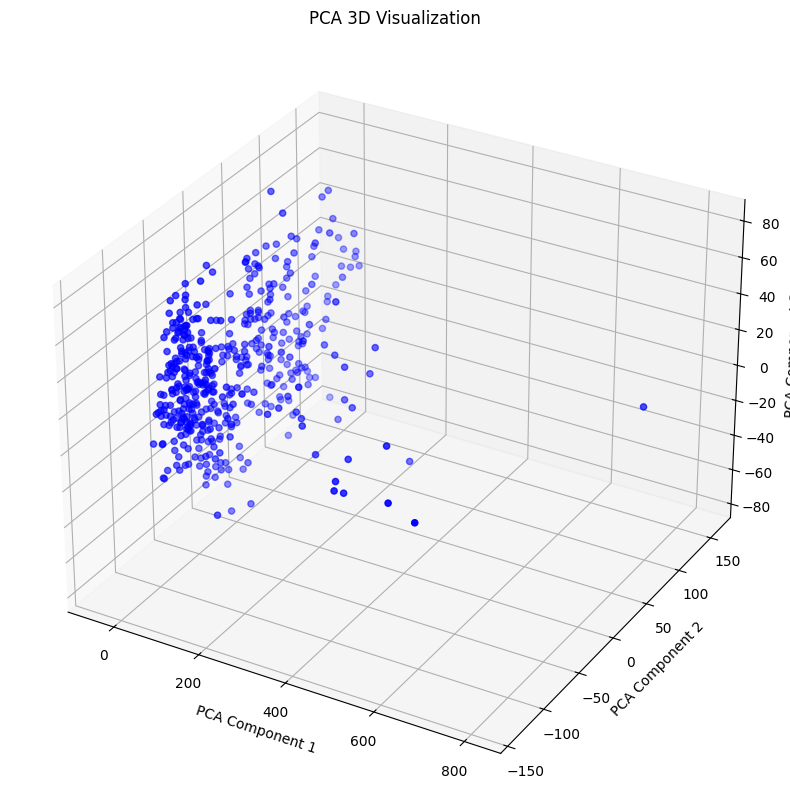

In [69]:
# Visualización 3D usando PCA
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c='blue', cmap='viridis')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('PCA 3D Visualization')
plt.show()



Usando ploty

In [70]:
import plotly.graph_objects as go

# Crear el gráfico 3D interactivo
fig = go.Figure(data=[go.Scatter3d(
    x=pca_result[:, 0],  
    y=pca_result[:, 1],  
    z=pca_result[:, 2],  
    mode='markers',
    marker=dict(
        size=5,
        color=pca_result[:, 0],  
        colorscale='Viridis',  
        opacity=0.8
    )
)])

# Configurar etiquetas de los ejes y título
fig.update_layout(
    scene=dict(
        xaxis_title='PCA Component 1',
        yaxis_title='PCA Component 2',
        zaxis_title='PCA Component 3'
    ),
    title='PCA 3D Visualization',
    width=800,
    height=600
)

# Mostrar el gráfico
fig.show()


t-SNE

In [72]:
# Aplicar t-SNE
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(data)
tsne

c:\Users\Serpa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



TSNE(n_components=3, n_iter=300, perplexity=30)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_26756\1270918115.py:6: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_26756\1270918115.py:12: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_26756\1270918115.py:18: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



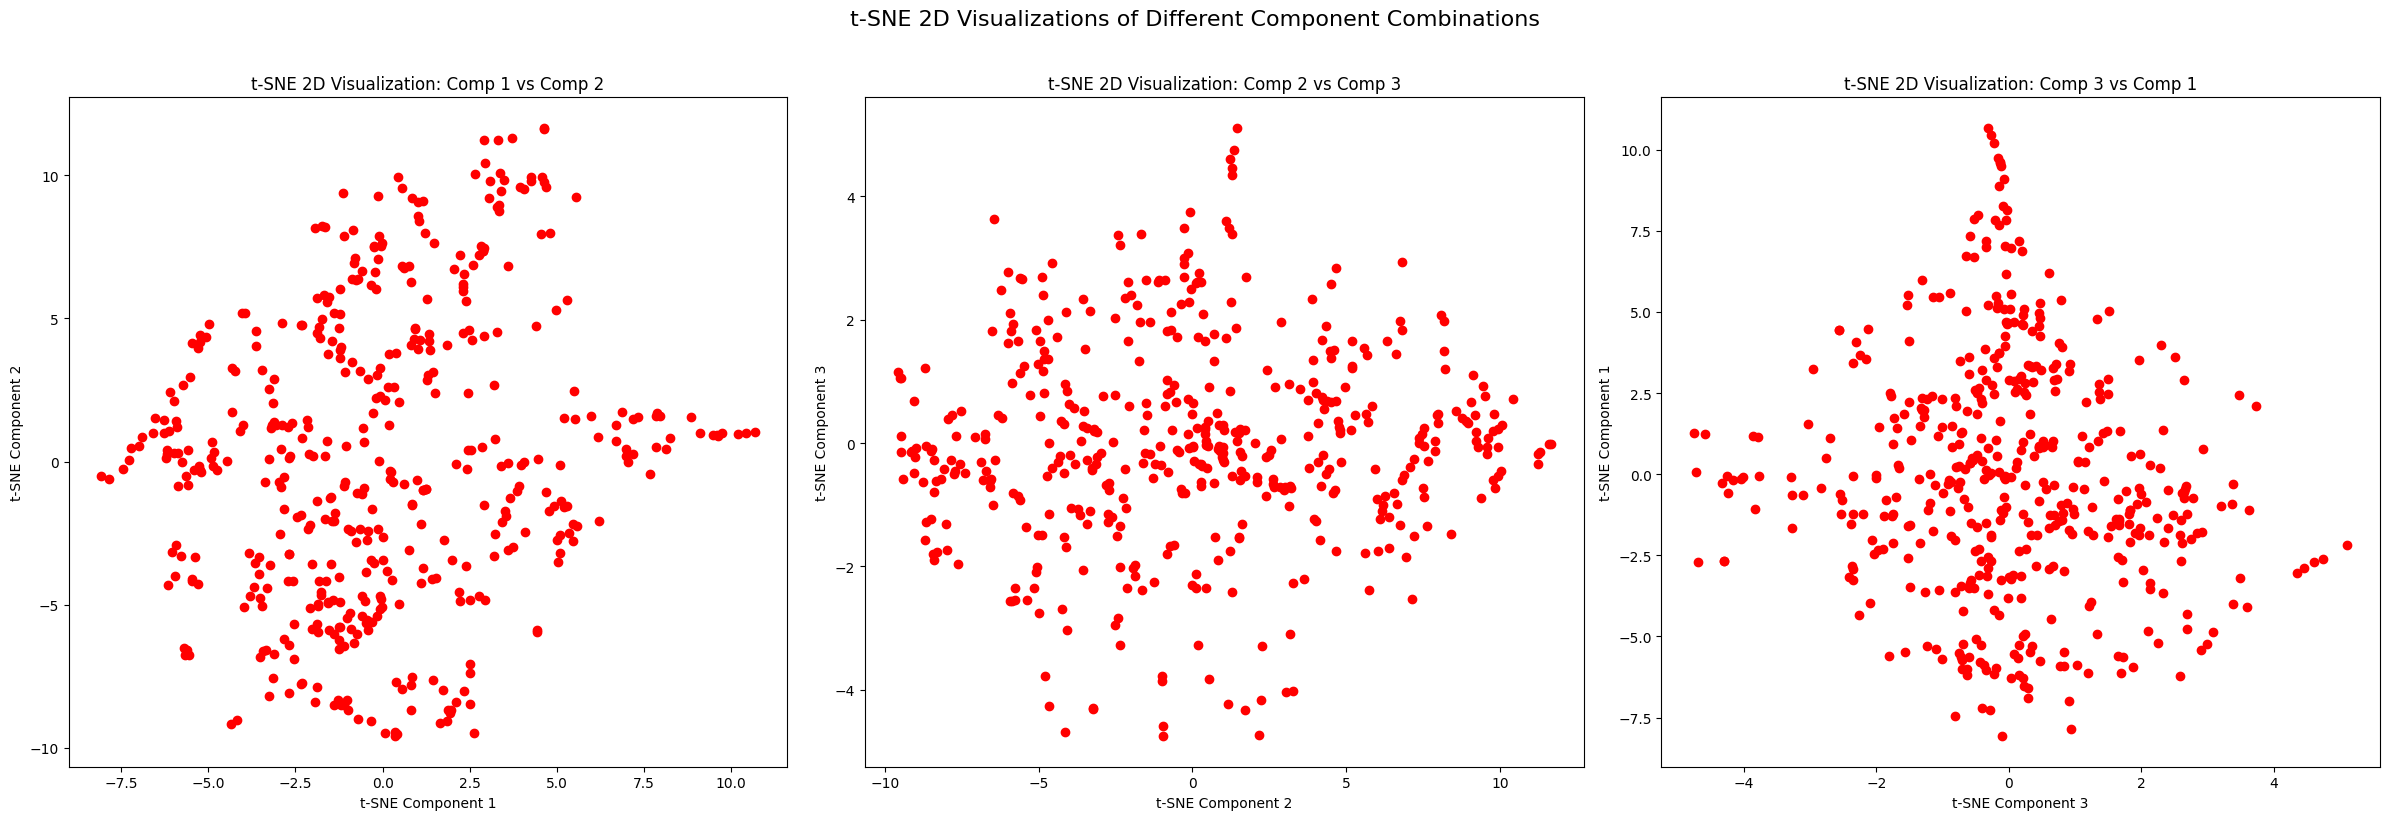

In [75]:
# Visualización 2D de los pca components
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('t-SNE 2D Visualizations of Different Component Combinations', fontsize=16, y=1.02)

# Primer subplot
axes[0].scatter(tsne_result[:, 0], tsne_result[:, 1], c='red', cmap='viridis')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
axes[0].set_title('t-SNE 2D Visualization: Comp 1 vs Comp 2')

# Segundo subplot
axes[1].scatter(tsne_result[:, 1], tsne_result[:, 2], c='red', cmap='viridis')
axes[1].set_xlabel('t-SNE Component 2')
axes[1].set_ylabel('t-SNE Component 3')
axes[1].set_title('t-SNE 2D Visualization: Comp 2 vs Comp 3')

# Tercer subplot
axes[2].scatter(tsne_result[:, 2], tsne_result[:, 0], c='red', cmap='viridis')
axes[2].set_xlabel('t-SNE Component 3')
axes[2].set_ylabel('t-SNE Component 1')
axes[2].set_title('t-SNE 2D Visualization: Comp 3 vs Comp 1')

plt.tight_layout()



Visualizacion 3d

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_26756\3371885600.py:4: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



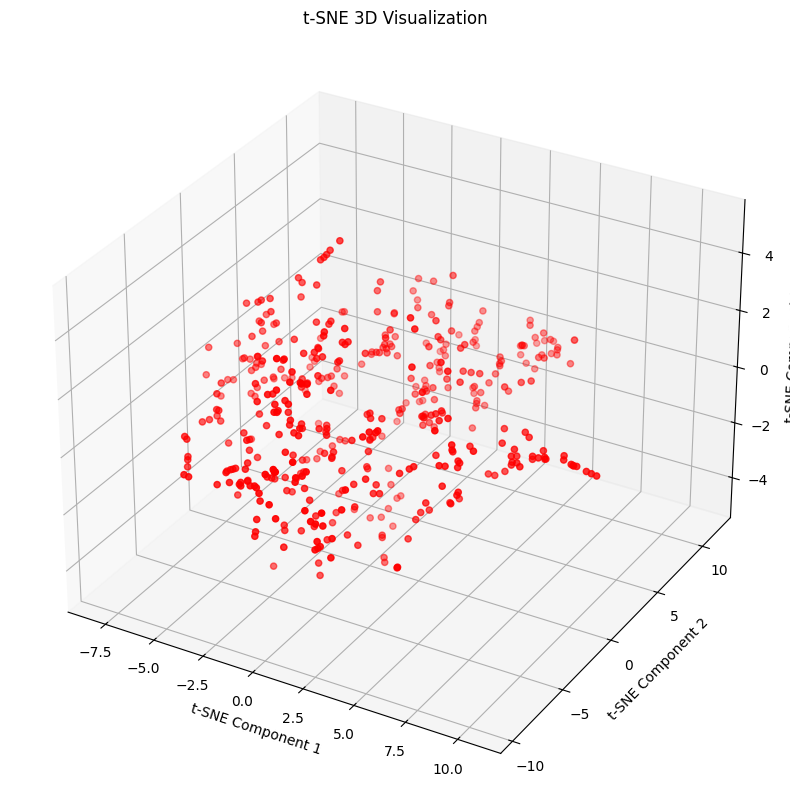

In [78]:
# Visualización 3D usando t-SNE
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], c='red', cmap='viridis')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.set_title('t-SNE 3D Visualization')
plt.show()

usando ploty

In [80]:
import plotly.graph_objects as go


import numpy as np
np.random.seed(44)

tsne_result = np.random.rand(100, 3)  # Ejemplo con 100 puntos en 3D

# Crear la figura
fig = go.Figure(data=go.Scatter3d(
    x=tsne_result[:, 0],
    y=tsne_result[:, 1],
    z=tsne_result[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color='red',  # Color de los puntos
        opacity=0.8
    )
))

# Configurar los ejes y el título
fig.update_layout(
    title='t-SNE 3D Visualization',
    scene=dict(
        xaxis_title='t-SNE Component 1',
        yaxis_title='t-SNE Component 2',
        zaxis_title='t-SNE Component 3',
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

# Mostrar la figura
fig.show()


## Red neuronal

In [134]:
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score    
from sklearn.metrics import f1_score

se van a usar los datos para predecir el raiting de la comunidad

In [111]:
data = pd.read_csv("data.csv")

### MLPRegressor para regresion (Taller 1 - Regresion lineal)

In [112]:
X = data_cleaned.drop('community rating', axis=1)
y = data_cleaned['community rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Red neuronal con relu

In [113]:
mlp_Regresion_relu = MLPRegressor(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)

In [114]:
mlp_Regresion_relu.fit(X_train, y_train)

MLPRegressor(max_iter=300, random_state=42)

#### Red neuronal con sigmoid

In [115]:
mlp_Regresion_sigmoid = MLPRegressor(
    hidden_layer_sizes=(100,),
    activation='logistic',
    solver='adam',
    max_iter=300,
    random_state=42
)

In [116]:
mlp_Regresion_sigmoid.fit(X_train, y_train)

c:\Users\Serpa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.



MLPRegressor(activation='logistic', max_iter=300, random_state=42)

#### Red neuronal con tanh

In [117]:
mlp_Regresion_tanh = MLPRegressor(
    hidden_layer_sizes=(100,),
    activation='tanh',
    solver='adam',
    max_iter=300,
    random_state=42
)

In [118]:
mlp_Regresion_tanh.fit(X_train, y_train)

c:\Users\Serpa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.



MLPRegressor(activation='tanh', max_iter=300, random_state=42)

#### Red neuronal con identity

In [119]:
mlp_Regresion_identity = MLPRegressor(
    hidden_layer_sizes=(100,),
    activation='identity',
    solver='adam',
    max_iter=300,
    random_state=42
)

In [120]:
mlp_Regresion_identity.fit(X_train, y_train)

MLPRegressor(activation='identity', max_iter=300, random_state=42)

##### Evaluacion de los modelos

In [121]:
y_pred_relu = mlp_Regresion_relu.predict(X_test)
y_pred_sigmoid = mlp_Regresion_sigmoid.predict(X_test)
y_pred_tanh = mlp_Regresion_tanh.predict(X_test)
y_pred_identity = mlp_Regresion_identity.predict(X_test)


In [122]:
print(f'R2 Score ReLU: {r2_score(y_test, y_pred_relu)}, MSE ReLU: {mean_squared_error(y_test, y_pred_relu)}')
print(f'R2 Score Sigmoid: {r2_score(y_test, y_pred_sigmoid)}, MSE Sigmoid: {mean_squared_error(y_test, y_pred_sigmoid)}')
print(f'R2 Score Tanh: {r2_score(y_test, y_pred_tanh)}, MSE Tanh: {mean_squared_error(y_test, y_pred_tanh)}')
print(f'R2 Score Identity: {r2_score(y_test, y_pred_identity)}, MSE Identity: {mean_squared_error(y_test, y_pred_identity)}')


R2 Score ReLU: -5.833670410689297, MSE ReLU: 1.473432224634283
R2 Score Sigmoid: -0.06775615571522842, MSE Sigmoid: 0.23022274024534745
R2 Score Tanh: -0.8902946701247079, MSE Tanh: 0.40757322399680046
R2 Score Identity: -0.541018342889074, MSE Identity: 0.3322645004379507


Conclusión, son malisimo los modelos

### MLPClassifier para clasificacion (Taller 1 - Clasificación)

In [105]:
def etiquetar_ratings(df):
   
    df['label'] = pd.cut(df['community rating'], bins=[-float('inf'), 2.5, 3.5, float('inf')],
                             labels=['Negativo', 'Neutral', 'Positivo'])
    return df

In [106]:
data2 = data.copy()

In [107]:
data2['community rating'] = pd.to_numeric(data2['community rating'], errors='coerce')

data2 = etiquetar_ratings(data2)


In [108]:
data2.to_csv("data2.csv", index=False)

In [123]:
X = data2.drop(['community rating', 'label'], axis=1)
y = data2['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Red Neuronal de clasificacion con Relu

In [124]:
mlp_Classifier_relu = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)

In [125]:
mlp_Classifier_relu.fit(X_train, y_train)

c:\Users\Serpa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.



MLPClassifier(max_iter=300, random_state=42)

Red neuronal de clasificacion con Sigmoid

In [126]:
mlp_Classifier_sigmoid = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='logistic',
    solver='adam',
    max_iter=300,
    random_state=42
)

In [127]:
mlp_Classifier_sigmoid.fit(X_train, y_train)

c:\Users\Serpa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.



MLPClassifier(activation='logistic', max_iter=300, random_state=42)

Red neuronal de clasificacion con tanh

In [128]:
mlp_Classifier_tanh = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='tanh',
    solver='adam',
    max_iter=300,
    random_state=42
)

In [129]:
mlp_Classifier_tanh.fit(X_train, y_train)

c:\Users\Serpa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.



MLPClassifier(activation='tanh', max_iter=300, random_state=42)

Red neuronal de clasificacion con identity

In [130]:
mlp_Classifier_identity = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='identity',
    solver='adam',
    max_iter=300,
    random_state=42
)

In [131]:
mlp_Classifier_identity.fit(X_train, y_train)

MLPClassifier(activation='identity', max_iter=300, random_state=42)

In [132]:
y_pred_relu = mlp_Classifier_relu.predict(X_test)
y_pred_sigmoid = mlp_Classifier_sigmoid.predict(X_test)
y_pred_tanh = mlp_Classifier_tanh.predict(X_test)
y_pred_identity = mlp_Classifier_identity.predict(X_test)


In [135]:

print(f'F1 Score ReLU: {f1_score(y_test, y_pred_relu, average="weighted")}')
print(f'F1 Score Sigmoid: {f1_score(y_test, y_pred_sigmoid, average="weighted")}')
print(f'F1 Score Tanh: {f1_score(y_test, y_pred_tanh, average="weighted")}')
print(f'F1 Score Identity: {f1_score(y_test, y_pred_identity, average="weighted")}')


F1 Score ReLU: 0.8616146622084276
F1 Score Sigmoid: 0.8655966156526067
F1 Score Tanh: 0.8612505018065034
F1 Score Identity: 0.8565234845443597
